In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from tensorflow.keras.regularizers import l2
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-07-10 21:11:11.600020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 21:11:11.603829: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 21:11:11.615173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752192671.634096   73777 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752192671.639716   73777 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752192671.654762   73777 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# 1. Carregar conjunto de dados

In [2]:
## Carregando os dados
df = pd.read_csv("data/train.csv")

# 2. Extração e tratamento de características

## 2.1 Criação de variável 'strata' para estratificação dos dados

In [3]:
##Criando variável para fazer divisão ideal dos dados
df['strata'] = df['Sex'].astype(str) + "_" + \
               df['Survived'].astype(str)

## 2.2 Extração de características 

In [4]:
##Engenharia de features
#Ajuste no nome por título
df["Name"] = df["Name"].str.extract(r',\s*([^\.]+)\.')

##Se possui cabine múltipla
df['Cabin_Multiple'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

##Prefixo da Cabine
df['Cabin_Pref'] = df['Cabin'].apply(lambda x: str(x)[0])

##Se o Ticket é numérico
df['Numeric_Ticket'] = df["Ticket"].apply(lambda x: 1 if x.isnumeric() else 0)

##Prefixo do Ticket
df["Prefix_Ticket"] = df["Ticket"].str.extract(r"^(.*?)(?=\s\d)")
df["Prefix_Ticket"] = df["Prefix_Ticket"].str.strip()
df["Prefix_Ticket"] = df["Prefix_Ticket"].fillna("n")

## 2.3 Tratamento de características

In [5]:
##Tratamento de dados
##Binarizando coluna 'Name'
df = pd.get_dummies(df, columns=['Name'], prefix='Name', dtype=int)

##Binarizar 'Sex'
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

##Binarizando 'Embarked'
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', dtype=int)

##Binarizando 'Cabin_Pref'
df = pd.get_dummies(df, columns=['Cabin_Pref'], prefix='Cabin_Pref', dtype=int)

##Binarizando 'Prefix_Ticket'
df = pd.get_dummies(df, columns=['Prefix_Ticket'], prefix='Prefix_Ticket', dtype=int)

In [6]:
##Tratamento de Nulos
##'Age'
df["Age"] = df["Age"].fillna(df["Age"].median())

##'Cabin'
df = df.drop(columns = {'Cabin'})

In [7]:
columns = ['strata', 'Pclass',
 'Age',
 'Parch',
 'Fare',
 'Survived',
 'Cabin_Multiple',
 'Sex',
 'Name_Master',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs',
 'Embarked_C',
 'Embarked_S',
 'Cabin_Pref_B',
 'Cabin_Pref_C',
 'Cabin_Pref_D',
 'Cabin_Pref_E',
 'Cabin_Pref_n',
 'Prefix_Ticket_PC']

df = df[columns]
df

,strata,Pclass,Age,Parch,Fare,Survived,Cabin_Multiple,Sex,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Embarked_C,Embarked_S,Cabin_Pref_B,Cabin_Pref_C,Cabin_Pref_D,Cabin_Pref_E,Cabin_Pref_n,Prefix_Ticket_PC
0,male_0,3,22.0,0,7.2500,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,female_1,1,38.0,0,71.2833,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1
2,female_1,3,26.0,0,7.9250,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,female_1,1,35.0,0,53.1000,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0
4,male_0,3,35.0,0,8.0500,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,male_0,2,27.0,0,13.0000,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
887,female_1,1,19.0,0,30.0000,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0
888,female_0,3,28.0,2,23.4500,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
889,male_1,1,26.0,0,30.0000,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   strata            891 non-null    object 
 1   Pclass            891 non-null    int64  
 2   Age               891 non-null    float64
 3   Parch             891 non-null    int64  
 4   Fare              891 non-null    float64
 5   Survived          891 non-null    int64  
 6   Cabin_Multiple    891 non-null    int64  
 7   Sex               891 non-null    int64  
 8   Name_Master       891 non-null    int64  
 9   Name_Miss         891 non-null    int64  
 10  Name_Mr           891 non-null    int64  
 11  Name_Mrs          891 non-null    int64  
 12  Embarked_C        891 non-null    int64  
 13  Embarked_S        891 non-null    int64  
 14  Cabin_Pref_B      891 non-null    int64  
 15  Cabin_Pref_C      891 non-null    int64  
 16  Cabin_Pref_D      891 non-null    int64  
 1

# 3. Divisão do conjunto de dados

In [9]:
# Separar X e y
X = df.drop(columns=['Survived', 'strata'])
y = df['Survived']
strata = df['strata']

# Etapa 1: treino (60%) e temp (40%)
X_train, X_temp, y_train, y_temp, strata_train, strata_temp = train_test_split(
    X, y, strata,
    test_size=0.3,
    stratify=strata,
    random_state=42
)

# Etapa 2: validação (20%) e teste (20%) a partir de temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=strata_temp,
    random_state=42
)

In [10]:
df_test_raw = X_test
df_raw_train = X_train

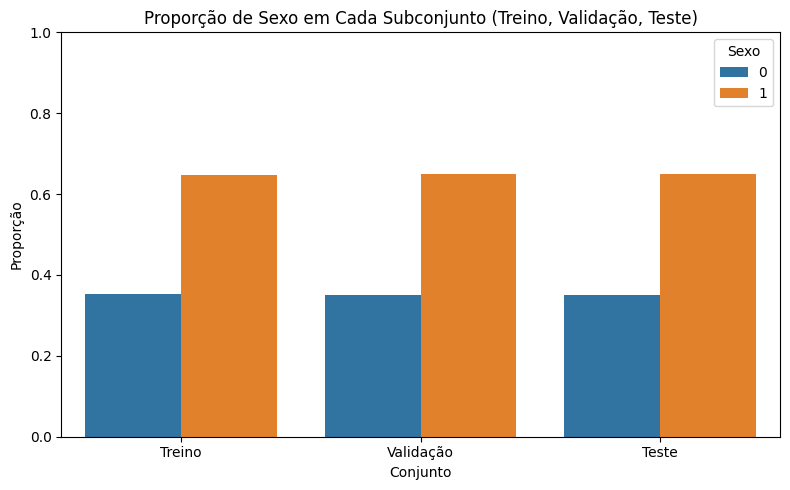

In [11]:
# Criar um DataFrame auxiliar com os conjuntos e seus respectivos sexos
def create_summary(df, name, coluna):
    return df[coluna].value_counts(normalize=True).rename_axis(coluna).reset_index(name='Proportion').assign(Subset=name)

summary_train = create_summary(X_train, 'Treino', 'Sex')
summary_val = create_summary(X_val, 'Validação', 'Sex')
summary_test = create_summary(X_test, 'Teste', 'Sex')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Sex')
plt.title('Proporção de Sexo em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

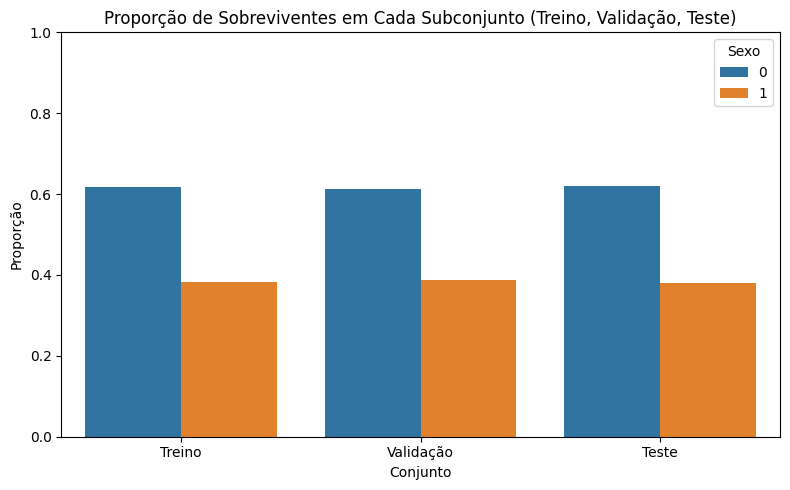

In [12]:
# Transformar as Series y_* em DataFrames com coluna nomeada
y_train_df = y_train.to_frame(name='Survived')
y_val_df = y_val.to_frame(name='Survived')
y_test_df = y_test.to_frame(name='Survived')

# Agora sim, aplicar a função corretamente
summary_train = create_summary(y_train_df, 'Treino', 'Survived')
summary_val = create_summary(y_val_df, 'Validação', 'Survived')
summary_test = create_summary(y_test_df, 'Teste', 'Survived')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Survived')
plt.title('Proporção de Sobreviventes em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

# 4. Normalização

In [13]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 5. Treinamento

In [14]:
##Modelo MLP
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/filipe-pinheiro/anaconda3/envs/main/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1752192673.547549   73777 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752192673.548231   73777 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

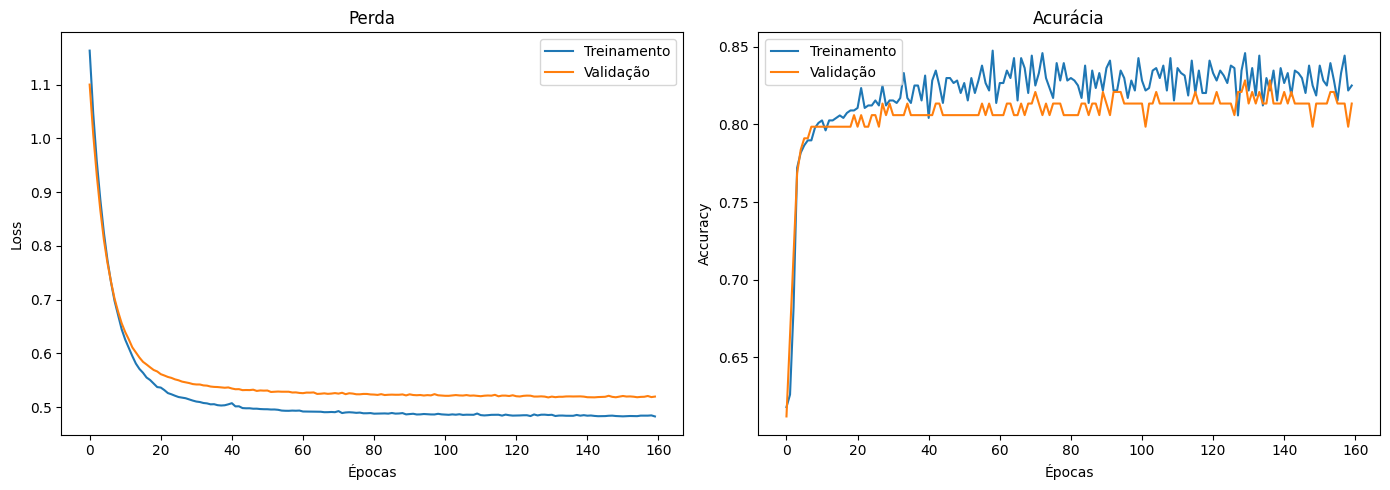

In [16]:
##Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        83
           1       0.74      0.78      0.76        51

    accuracy                           0.81       134
   macro avg       0.80      0.81      0.80       134
weighted avg       0.82      0.81      0.81       134

Matriz de Confusão:
[[69 14]
 [11 40]]


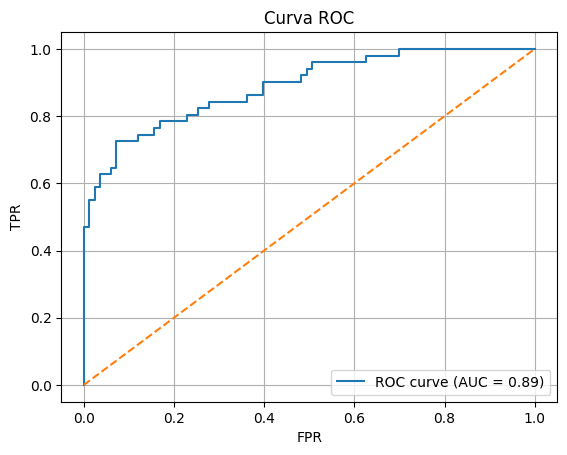

In [17]:
##Avaliação
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Análise de erro

/tmp/ipykernel_73777/3118115229.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_class = df_result.groupby('Pclass').apply(
/tmp/ipykernel_73777/3118115229.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')


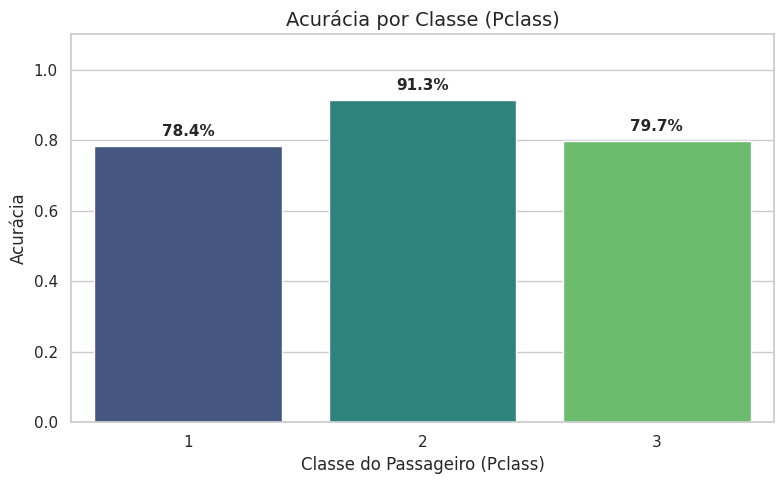

In [18]:
#@Juntar com a coluna Pclass (que vem da versão original dos dados)
df_result = pd.DataFrame({
    'Pclass': df_test_raw['Pclass'].values,
    'y_true': y_test,
    'y_pred': y_pred
})
##Calcular acurácia por Pclass
acc_by_class = df_result.groupby('Pclass').apply(
    lambda g: accuracy_score(g['y_true'], g['y_pred'])
).reset_index(name='accuracy')

##Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')

#Adicionar porcentagens no topo das barras
for i, row in acc_by_class.iterrows():
    acc_percent = f"{row['accuracy']*100:.1f}%"
    ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acurácia por Classe (Pclass)', fontsize=14)
plt.xlabel('Classe do Passageiro (Pclass)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.1)  # Deixar espaço para o texto acima das barras
plt.tight_layout()
plt.show()

/tmp/ipykernel_73777/3100036911.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby('Sex').apply(
/tmp/ipykernel_73777/3100036911.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x='Sex', y='accuracy', palette='magma')


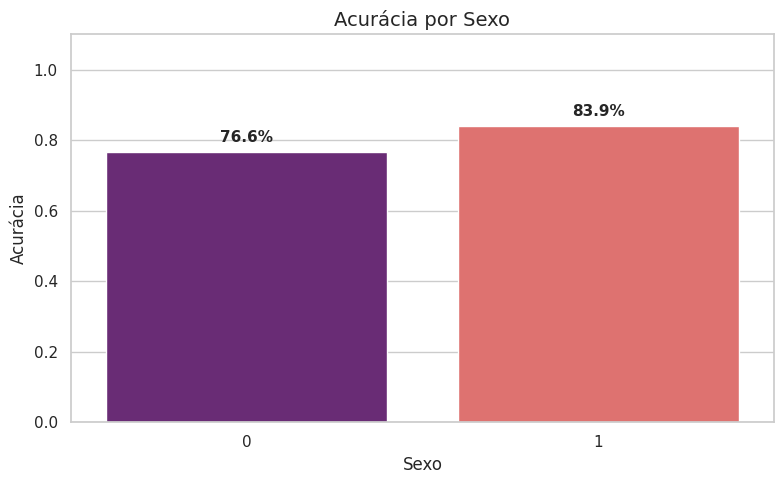

In [19]:
df_result = pd.DataFrame({
    'Sex': df_test_raw['Sex'].values,
    'y_true': y_test,
    'y_pred': y_pred
})

##Calcular acurácia por sexo
acc_by_sex = df_result.groupby('Sex').apply(
    lambda g: accuracy_score(g['y_true'], g['y_pred'])
).reset_index(name='accuracy')

##Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=acc_by_sex, x='Sex', y='accuracy', palette='magma')

#Adicionar porcentagens no topo das barras
for i, row in acc_by_sex.iterrows():
    acc_percent = f"{row['accuracy']*100:.1f}%"
    ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acurácia por Sexo', fontsize=14)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


In [20]:
df_raw_train['Pclass'].value_counts()

Pclass
3    342
1    147
2    134
Name: count, dtype: int64

In [21]:
pd.crosstab(df_raw_train['Pclass'], y_train, normalize='index')


Survived,0,1
Pclass,,
1,0.367347,0.632653
2,0.514925,0.485075
3,0.763158,0.236842
